In [34]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [35]:
x_position = ctrl.Antecedent(np.arange(-1, 1, 0.01), 'x_position')
y_position = ctrl.Antecedent(np.arange(-1, 1, 0.01), 'y_position')
ang_v = ctrl.Antecedent(np.arange(-8, 8, 0.01), 'ang_v')
torque = ctrl.Consequent(np.arange(-2, 2, 0.01), 'torque')

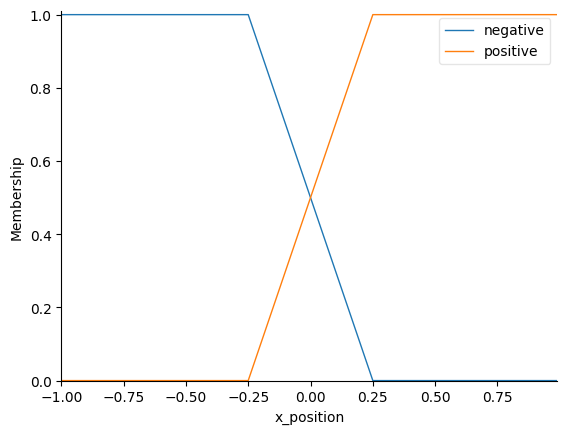

In [36]:
x_position['negative'] = fuzz.trapmf(x_position.universe, [-1, -1, -0.25, 0.25])
x_position['positive'] = fuzz.trapmf(x_position.universe, [-0.25, 0.25, 1, 1])
x_position.view()

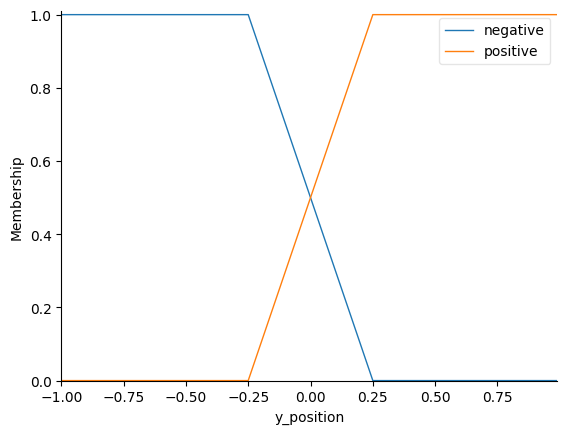

In [37]:
y_position['negative'] = fuzz.trapmf(y_position.universe, [-1, -1, -0.25, 0.25])
y_position['positive'] = fuzz.trapmf(y_position.universe, [-0.25, 0.25, 1, 1])
y_position.view()

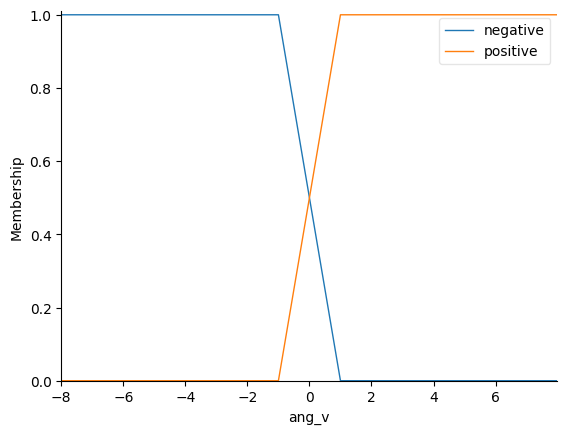

In [38]:
ang_v['negative'] = fuzz.trapmf(ang_v.universe, [-8, -8, -1, 1])
ang_v['positive'] = fuzz.trapmf(ang_v.universe, [-1, 1, 8, 8])
ang_v.view()

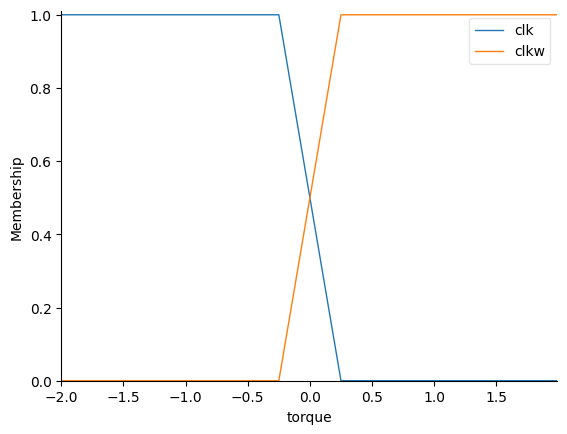

In [39]:
torque['clk'] = fuzz.trapmf(torque.universe, [-2, -2, -0.25, 0.25])
torque['clkw'] = fuzz.trapmf(torque.universe, [-0.25, 0.25, 2, 2])
torque.view()

In [40]:
rules = [
    ctrl.Rule(x_position['negative'] & y_position['negative'] & ang_v['negative'], torque['clk']),
    ctrl.Rule(x_position['negative'] & y_position['negative'] & ang_v['positive'], torque['clkw']),
    ctrl.Rule(x_position['negative'] & y_position['positive'] & ang_v['negative'], torque['clk']),
    ctrl.Rule(x_position['negative'] & y_position['positive'] & ang_v['positive'], torque['clkw']),
    ctrl.Rule(x_position['positive'] & y_position['negative'] & ang_v['negative'], torque['clkw']),
    ctrl.Rule(x_position['positive'] & y_position['negative'] & ang_v['positive'], torque['clk']),
    ctrl.Rule(x_position['positive'] & y_position['positive'] & ang_v['negative'], torque['clkw']),
    ctrl.Rule(x_position['positive'] & y_position['positive'] & ang_v['positive'], torque['clk']),
]

In [41]:
controller = ctrl.ControlSystem(rules)
simulator = ctrl.ControlSystemSimulation(controller)

In [42]:
env = gym.make("Pendulum-v1", render_mode="human")

In [43]:
observation, info = env.reset(seed=42)

rewards = []
velocities = []
x_positions = []

for _ in range(500):
    env.render()
    x = observation[0]
    y = observation[1]
    v = observation[2]
    if x > 0.99 and abs(v) < 1:
        print(f"You Win in {_} iteration")
        terminated = True
        break
    simulator.input['x_position'] = x
    simulator.input['y_position'] = y
    simulator.input['ang_v'] = v
    simulator.compute()
    action = simulator.output['torque']
    observation, reward, terminated, truncated, info = env.step([action])
    
    rewards.append(reward)
    velocities.append(v)
    x_positions.append(x)

env.close()

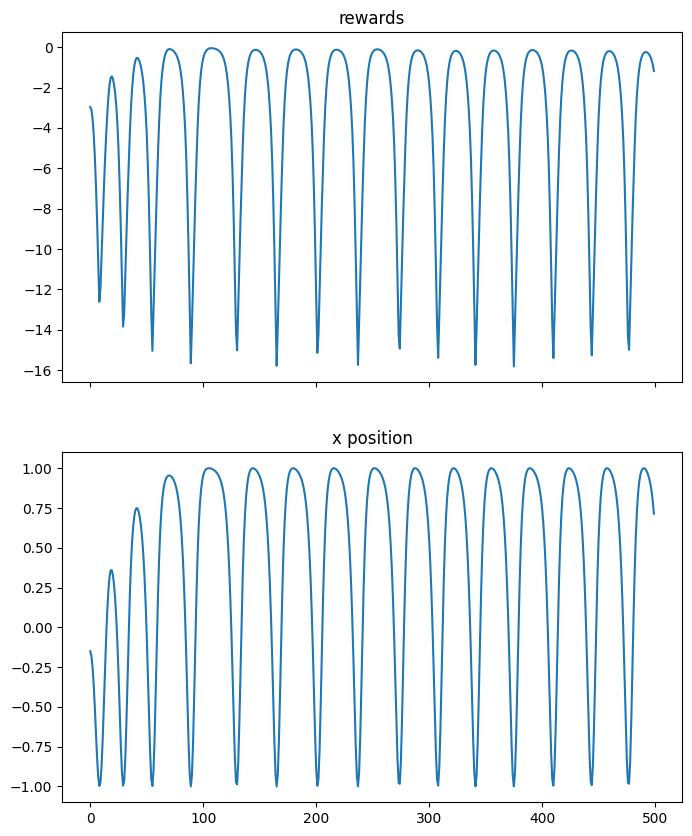

In [44]:

fix, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
axs[0].plot(range(len(rewards)), rewards)
axs[1].plot(range(len(x_positions)), x_positions)

axs[0].set_title('rewards')
axs[1].set_title('x position')

plt.show()